# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

- Se o bloco abaixo der erro no seu computador, pesquise pelo programa "prompt Anaconda" e execute os seguintes códigos de instalação:
    - pip install seaborn
    - pip install plotly
    - pip install tensorflow

In [2]:
import pandas as pd
import datetime
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
# Importar Tensorflow
import tensorflow as tf

#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

### Importar as bases de dados

Criar um dicionário com os 3 primeiros caracteres com os nomes dos meses e o número correspondente daquele mês.

Para cada arquivo da base de dados vamos importar os dados do arquivo e criar uma coluna com o mês e o ano de cada informação

In [3]:
meses = {'jan': 1, 'fev':2, 'mar':3, 'abr': 4, 'mai':5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = pathlib.Path('dataset')

base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]
    
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
    
    df = pd.read_csv(caminho_bases / arquivo.name, low_memory=False)
    df['ano'] = ano
    df['mes'] = mes
    base_airbnb = base_airbnb.append(df)

# display(base_airbnb)

C:\Users\Thiago Kato\AppData\Local\Temp\ipykernel_8968\2578543292.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_airbnb = base_airbnb.append(df)
C:\Users\Thiago Kato\AppData\Local\Temp\ipykernel_8968\2578543292.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_airbnb = base_airbnb.append(df)
C:\Users\Thiago Kato\AppData\Local\Temp\ipykernel_8968\2578543292.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_airbnb = base_airbnb.append(df)
C:\Users\Thiago Kato\AppData\Local\Temp\ipykernel_8968\2578543292.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_airbnb = base_airbnb.append(df)
C:\Users\Thiago Kato

### Tratamento dos dados

- Como temos muitas informações, o modelo pode acabar ficando muito lento.
- Uma análise inicial indica que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir estas colunas da nossa base
- Tipos de colunas que vamos excluir:
    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês)
    3. Colunas preenchidas com texto livre -> Não faremos qualquer análise de palavras ou algo do tipo (Para um projeto futuro podemos utilizar uma análise de sentimento das postagens com o auxílio de uma IA)
    4. Colunas em que todos ou quase todos os valores são iguais
    
- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa, olhando as colunas e identificando quais são desnecessárias

In [4]:
# print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

### Com uma análise qualitativa das colunas, e considerando os critérios de exclusão definidos acima, ficaremos com as seguintes colunas:


In [5]:
colunas = ['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count',
           'latitude', 'longitude',
           'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 
           'price', 'security_deposit', 'cleaning_fee',
           'guests_included','extra_people',
           'minimum_nights','maximum_nights',
           'number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
           'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value',
           'instant_bookable',
           'is_business_travel_ready',
           'cancellation_policy',
           'ano','mes']

base_airbnb = base_airbnb.loc[:, colunas]
# print(list(base_airbnb.columns))
# display(base_airbnb)

### Tratar Valores Faltando

- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN foram excluídas da análise
- Para as outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém dados NaN

In [6]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


- Agora vamos excluir as linhas vazias

In [7]:
base_airbnb = base_airbnb.dropna()

print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

- Tratar colunas de texto que deveriam ser um número

In [8]:
print(base_airbnb.dtypes)
print('#'*50)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
##################################################
host_is_superhost                                                           f
host_listings_count          

- price e extra people estão sendo reconhecidos como objeto (ao invés de ser um número)

In [9]:
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)
#extra people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)
#verificando os tipos
print(base_airbnb.dtypes)

C:\Users\Thiago Kato\AppData\Local\Temp\ipykernel_8968\4022817052.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
C:\Users\Thiago Kato\AppData\Local\Temp\ipykernel_8968\4022817052.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')


host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de (Q1 - 1.5 x Amplitude) e valores acima de (Q3 + 1.5 x Amplitude)). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem sentido para o nosso modelo ou se alguma delas não vai nos ajudar e devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

ATENÇÃO AO AVALIAR OUTLIERS: Avalie se há um motivo claro para remover o outlier, talvez não seja necessário e pode prejudicar o modelo.

C:\Users\Thiago Kato\AppData\Local\Temp\ipykernel_8968\3856035136.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')


<Axes: >

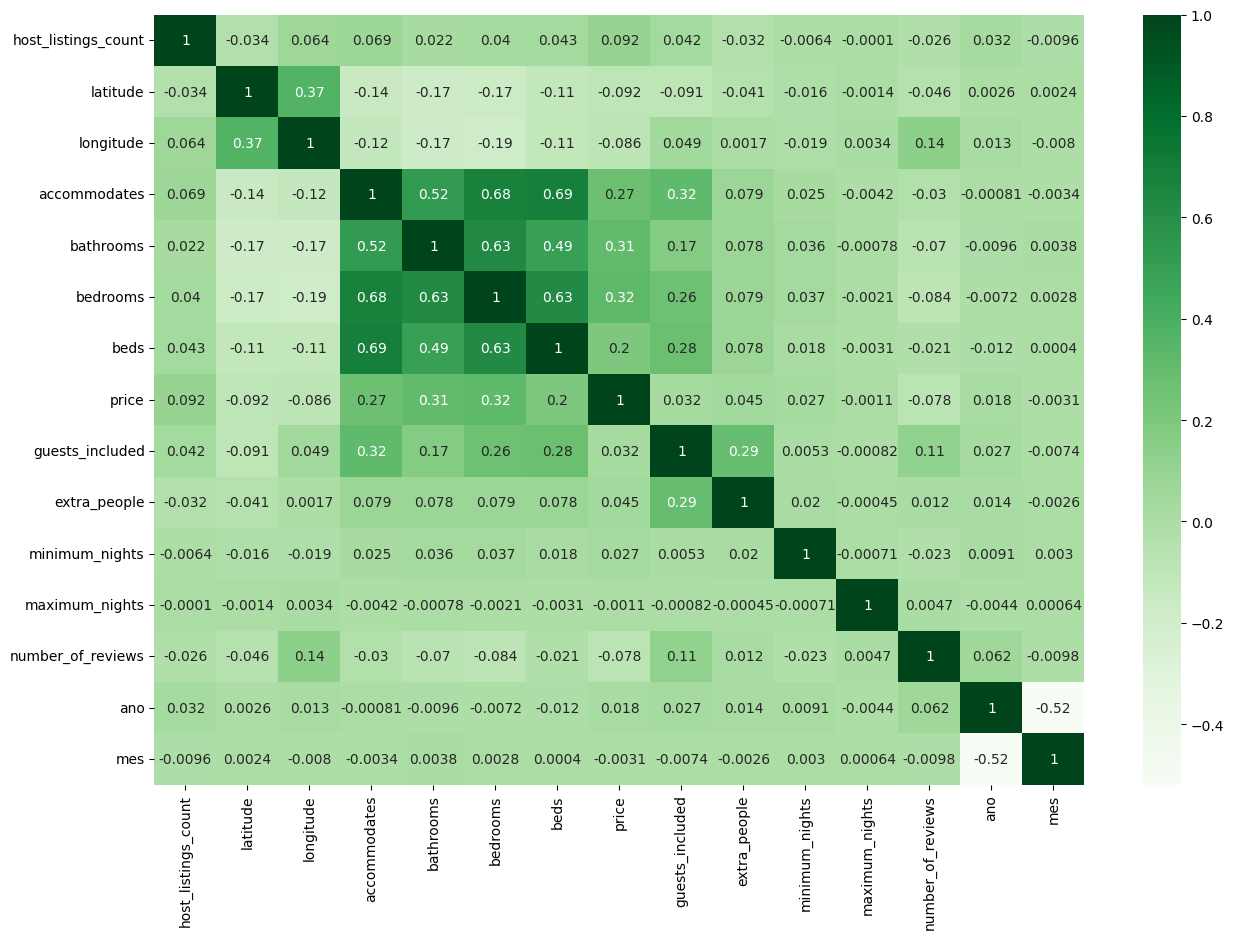

In [10]:
plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')

### Funções para Análise de Outliers

Definir funções para auxiliar na análise de outliers das colunas

In [11]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

In [12]:
# Funções para geração de gráficos de análise
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15, 5)).set_figwidth(15)
    sns.displot(coluna, kind='kde')
    ax2 = plt.twinx()
    ax2 = sns.histplot(coluna, ax=ax2, color='red', binwidth=5)
    plt.show()

def grafico_barra(coluna):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### price

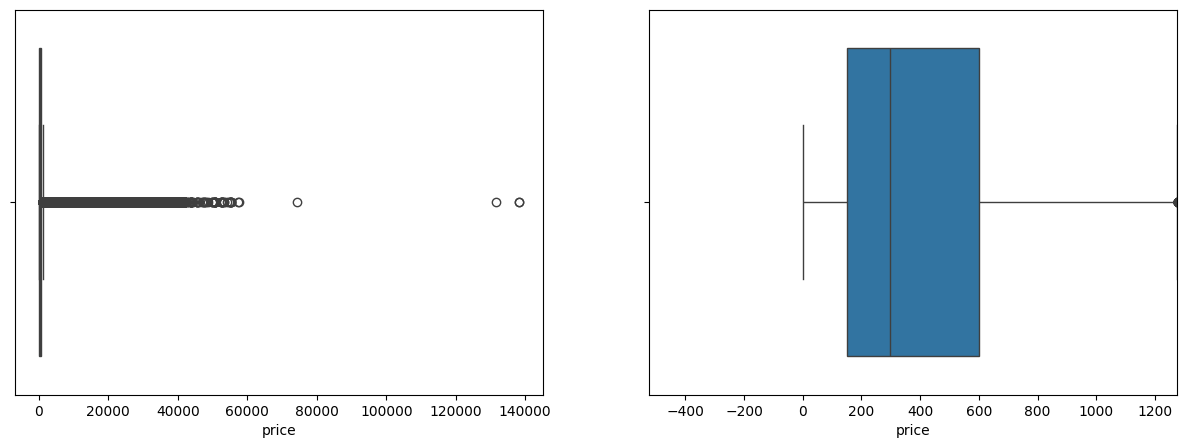

<Figure size 1500x500 with 0 Axes>

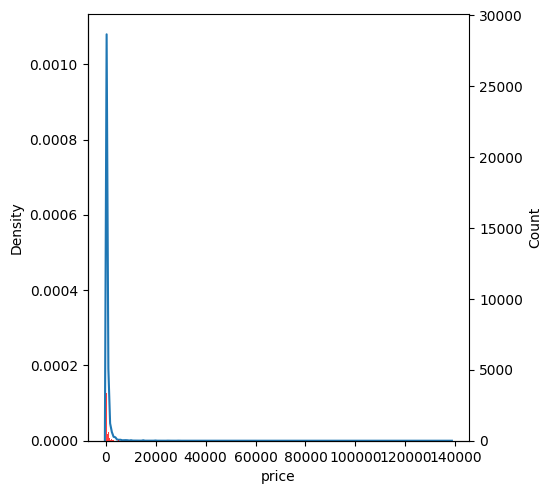

In [13]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

Estamos construindo um modelo para imóveis comuns. Valores acima do limite superior serão apenas de apartamentos de altíssimo luxo. Não é o nosso objetivo principal e por isso, podemos excluir esses outliers.

In [14]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


<Figure size 1500x500 with 0 Axes>

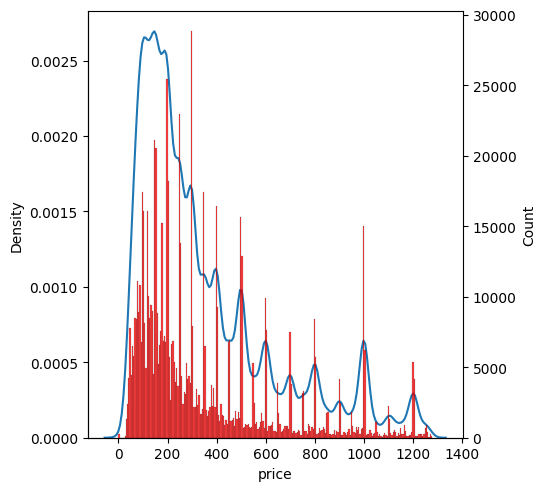

(810427, 23)


In [15]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

### extra_people

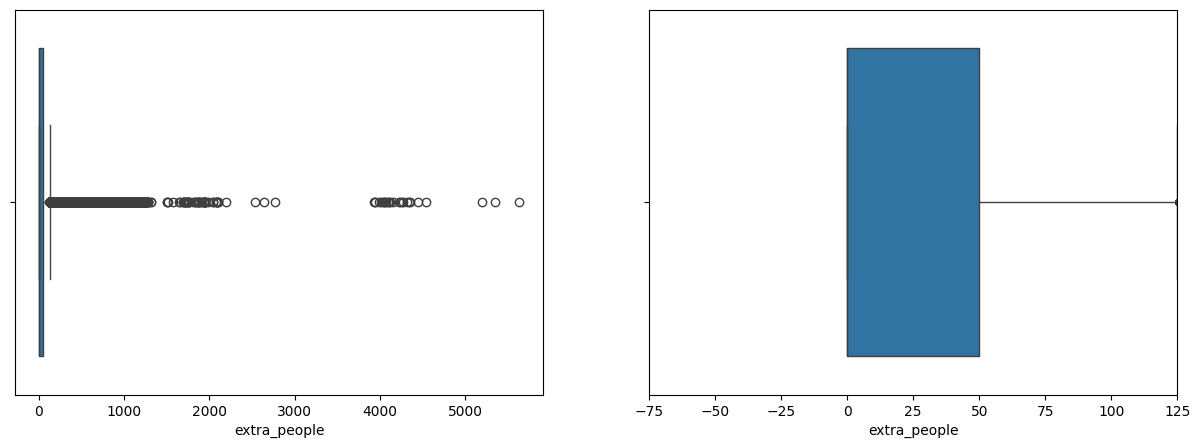

<Figure size 1500x500 with 0 Axes>

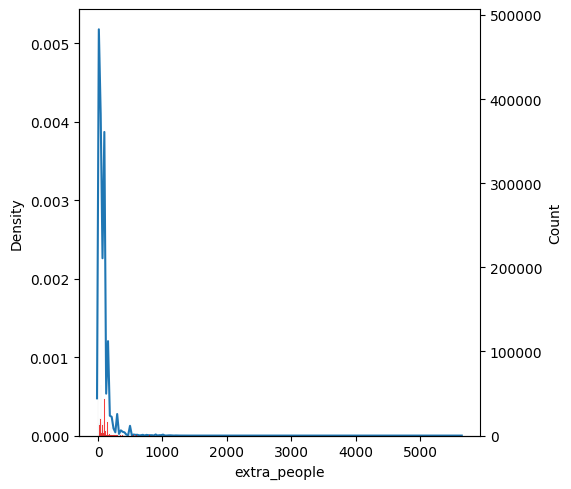

In [16]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [17]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

59194 linhas removidas


<Figure size 1500x500 with 0 Axes>

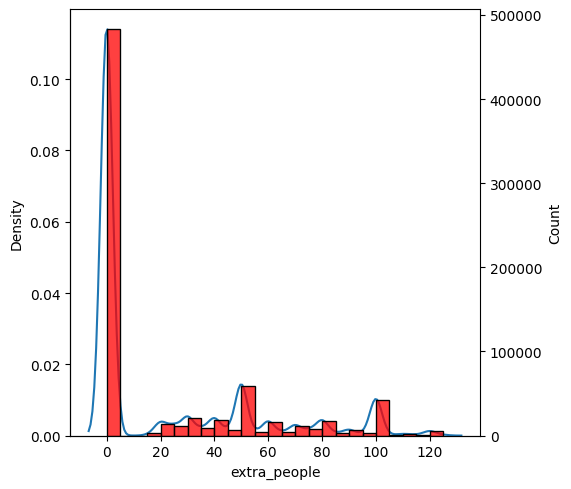

(751233, 23)


In [18]:
histograma(base_airbnb['extra_people'])
print(base_airbnb.shape)

### host_listings_count

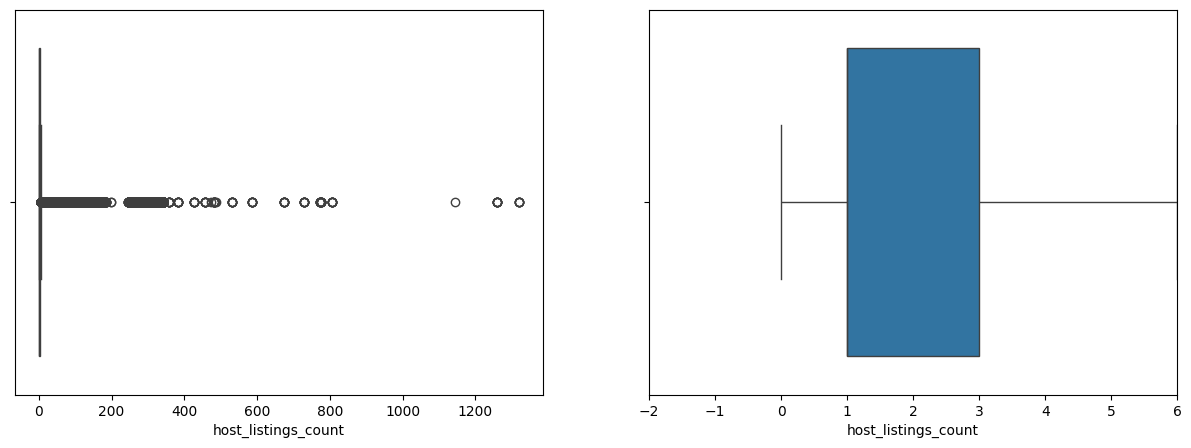

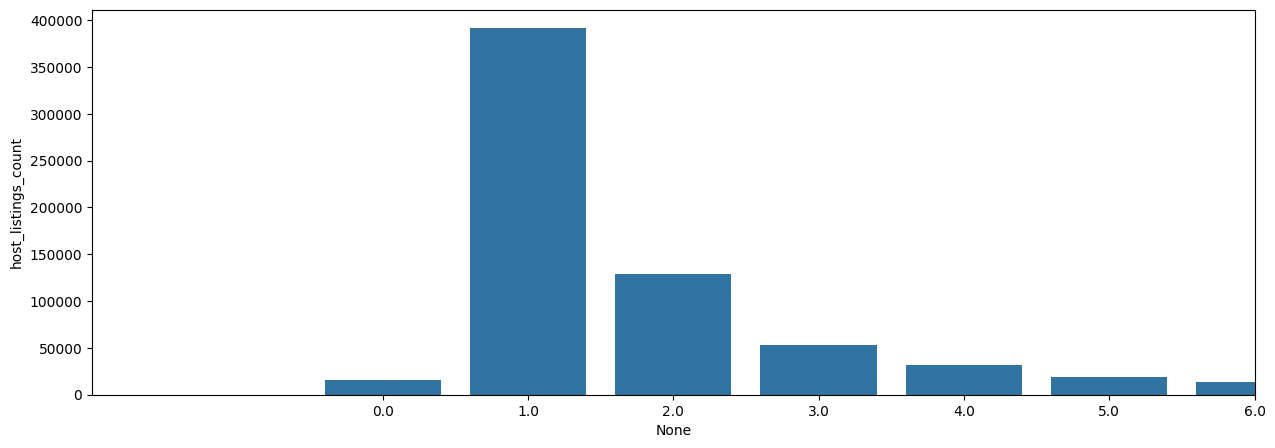

In [19]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Excluir os outliers, pois para o objetivo do nosso projeto, não vamos comparar hosts individuais com hosts com mais de 6 imóveis no airbnb (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [20]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


### accommodates

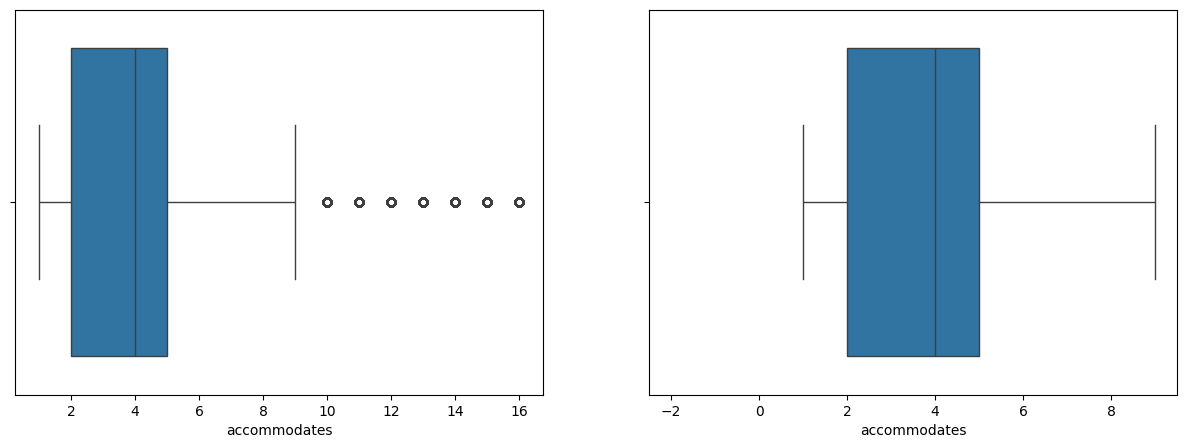

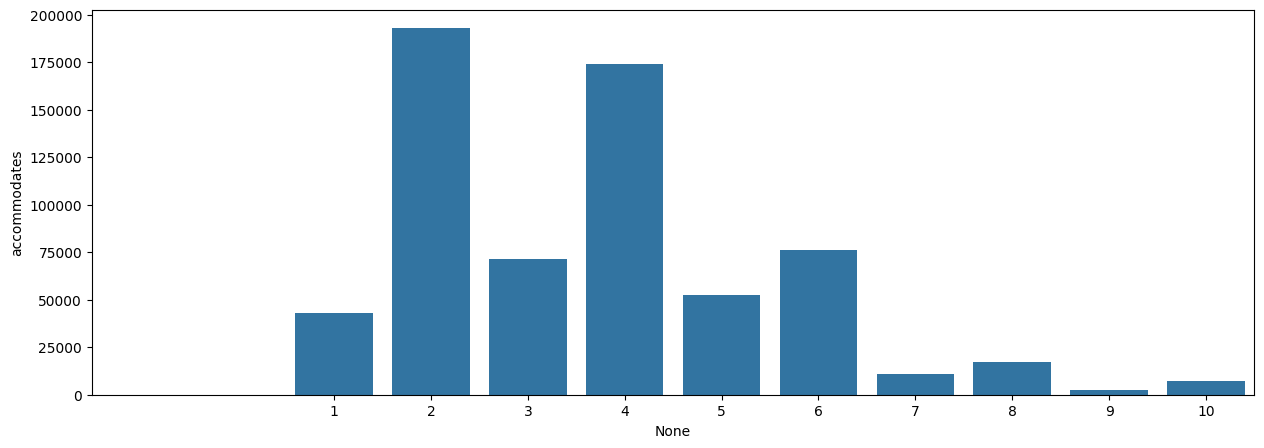

In [21]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

- Pelo mesmo motivo do "host_listings_count" vamos excluir os outliers dessa coluna pois apartamentos que acomodam mais de 9 pessoas não são o nosso foco, nosso objetivo aqui é para imóveis comuns.

- Caso quisessemos incluir apartamentos de alto padrão, poderiamos manter essa variável ou então construir um modelo só focado em imóvei com mais de 9 hóspedes

In [22]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


### bathrooms 

<Axes: xlabel='None', ylabel='bathrooms'>

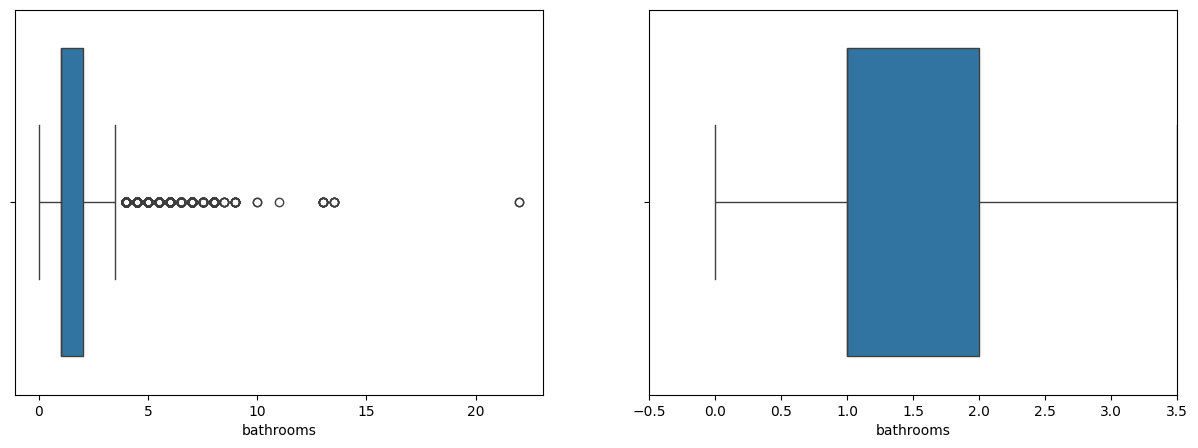

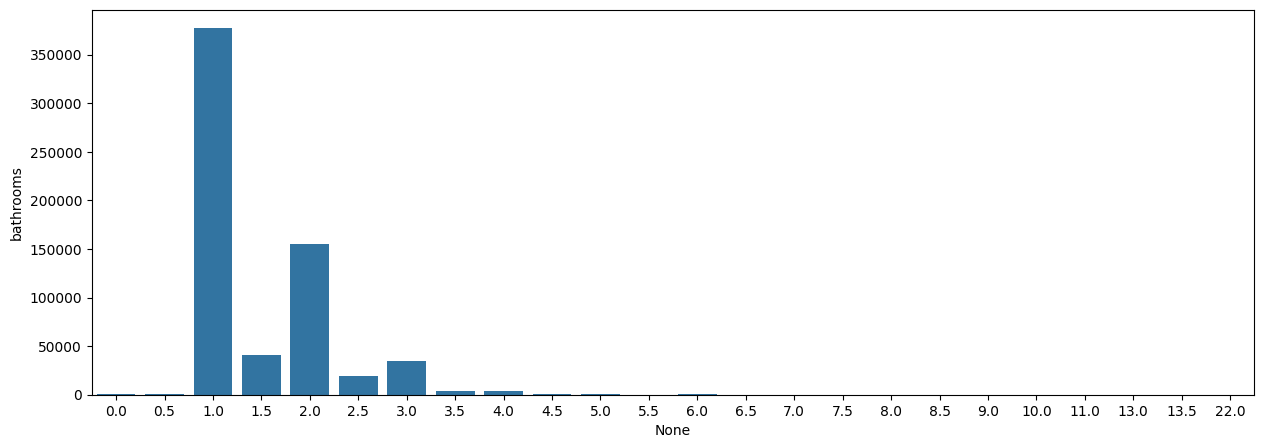

In [23]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

- Pelo mesmo motivo dos anteriores, vamos excluir os outliers da feature bathrooms

In [24]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


### bedrooms

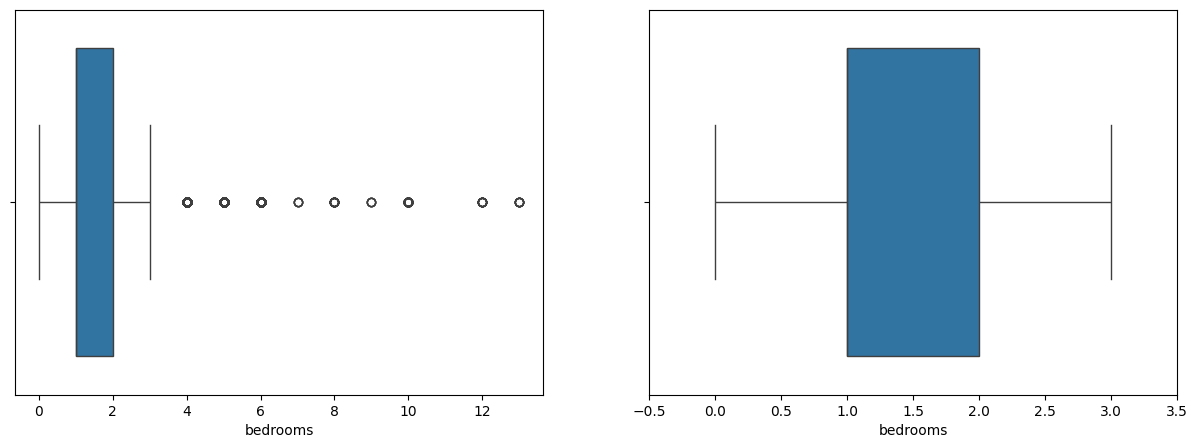

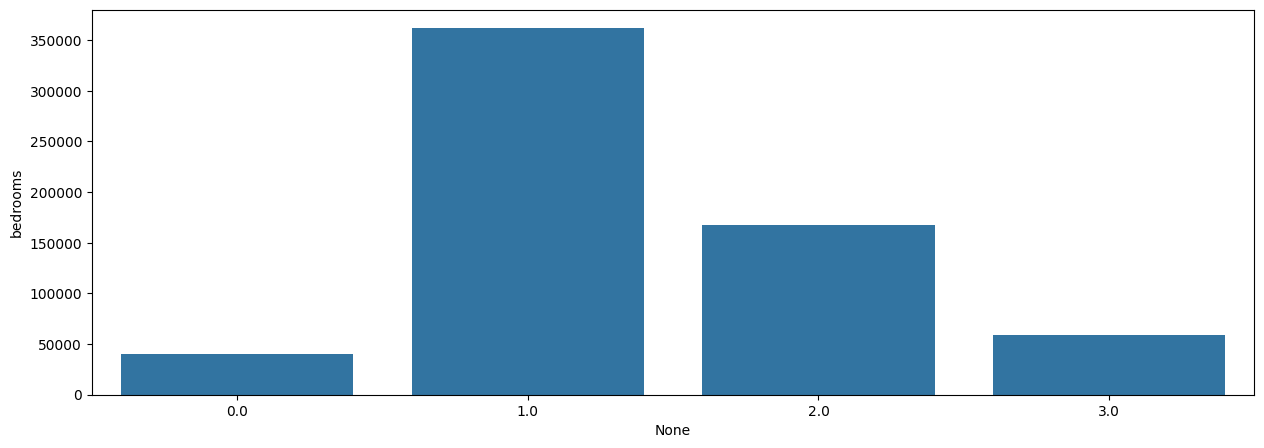

In [25]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

- Pelo mesmo motivo dos anteriores, vamos excluir outliers em quantidade de quartos

In [26]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


### beds

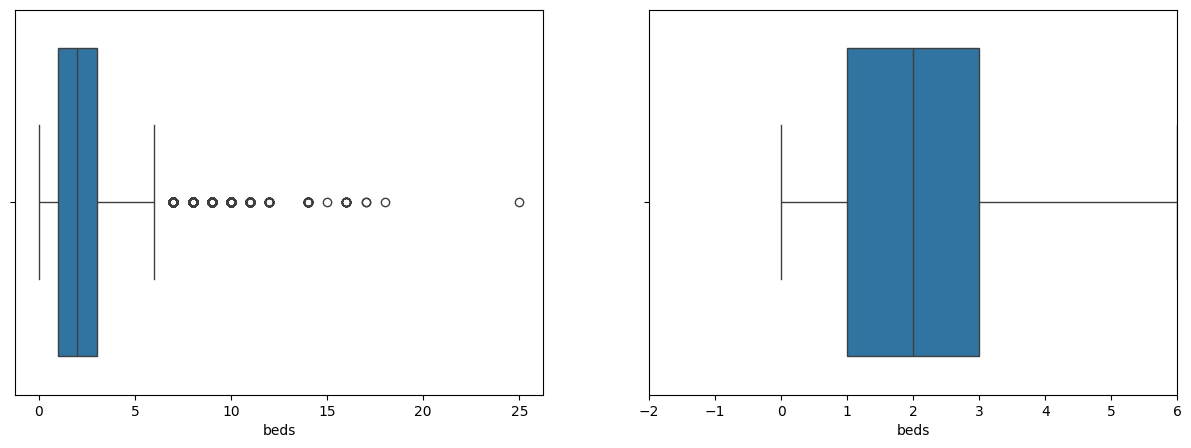

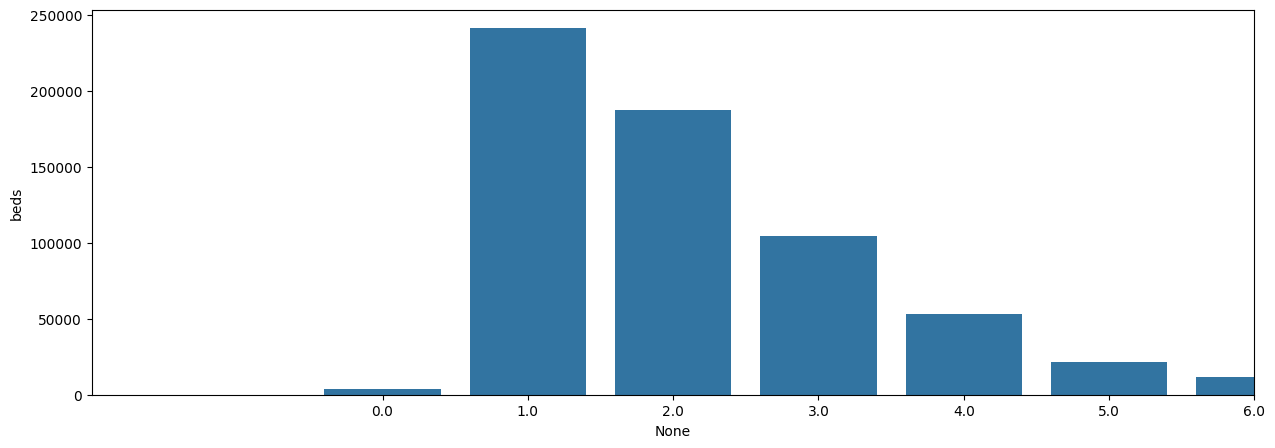

In [27]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

- Pelo mesmo motivo dos anteriores, vamos excluir outliers em quantidade de camas

In [28]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
# print('{} linhas removidas'.format(linhas_removidas))

### guests_included

(1.0, 1.0)


<Axes: xlabel='None', ylabel='guests_included'>

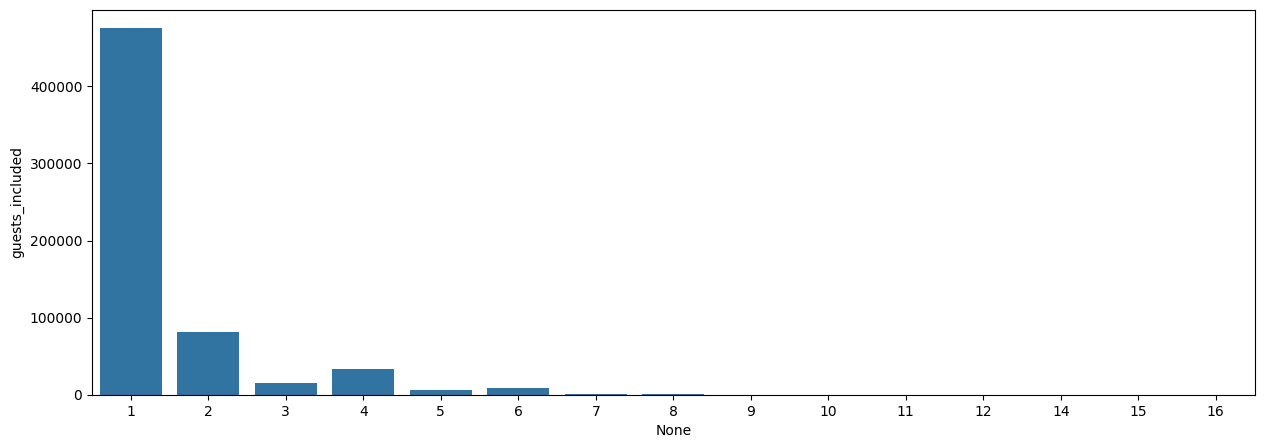

In [29]:
#diagrama_caixa(base_airbnb['guests_included'])
#grafico_barra(base_airbnb['guests_included'])
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

Vamos remover essa feature da análise. Os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

In [30]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

### minimum_nights

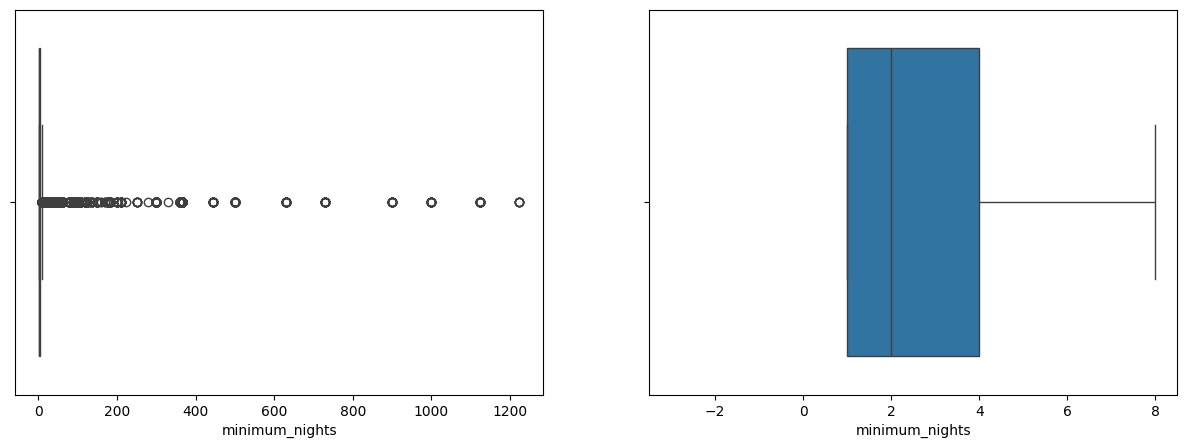

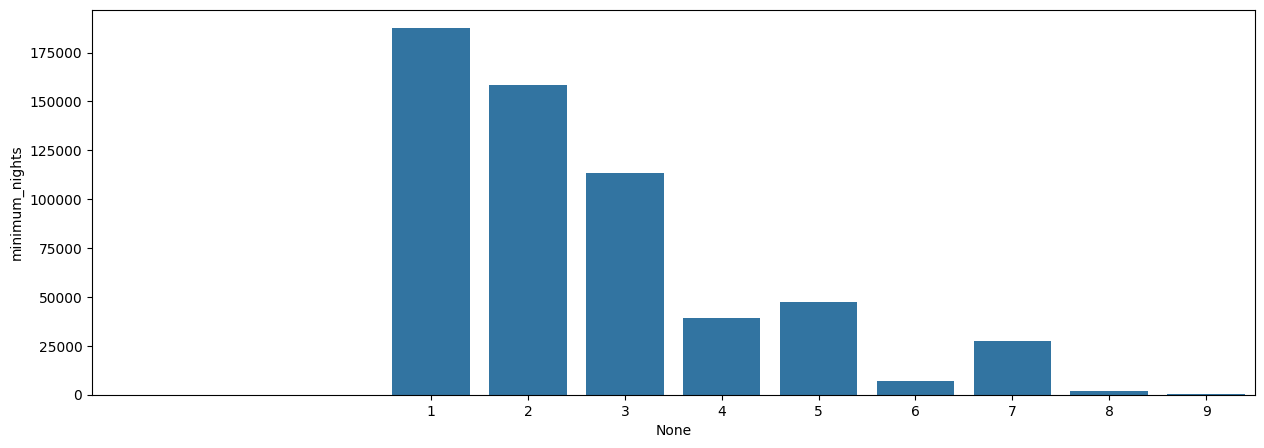

In [31]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

- Aqui temos um motivo talvez até mais forte para excluir esses apartamentos da análise.

- Estamos querendo um modelo que ajude a precificar apartamentos comuns como uma pessoa comum gostaria de disponibilizar. No caso, apartamentos com mais de 8 noites como o "mínimo de noites" podem ser apartamentos de temporada ou ainda apartamentos para morar, em que o host exige pelo menos 1 mês no apartamento.

- Por isso, vamos excluir os outliers dessa coluna

In [32]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

40383 linhas removidas


### maximum_nights

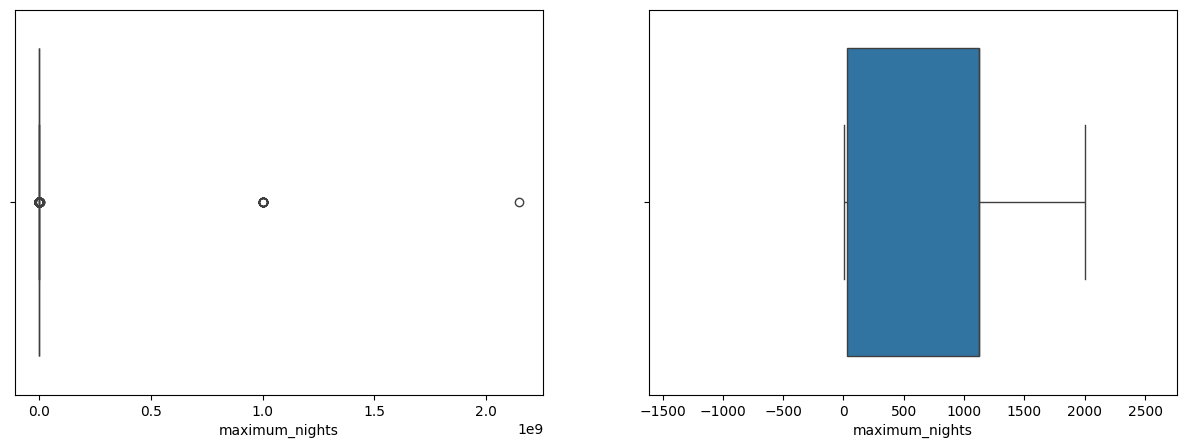

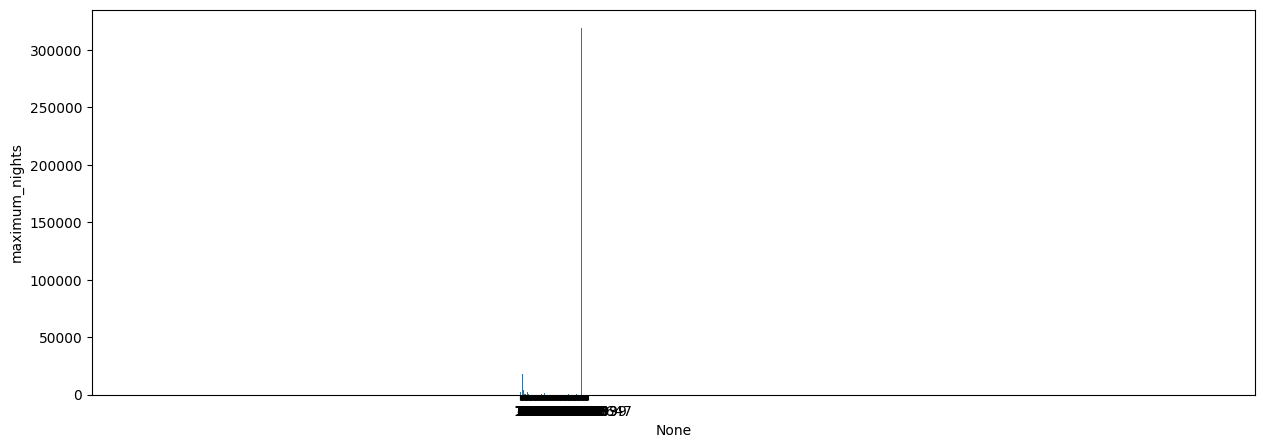

In [33]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

- Essa coluna não parece que vai ajudar na análise.

- Isso porque parece que quase todos os hosts não preenchem esse campo de maximum nights, então ele não parece que vai ser um fator relevante.

- É melhor excluirmos essa coluna da análise

In [34]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

### number_of_reviews            

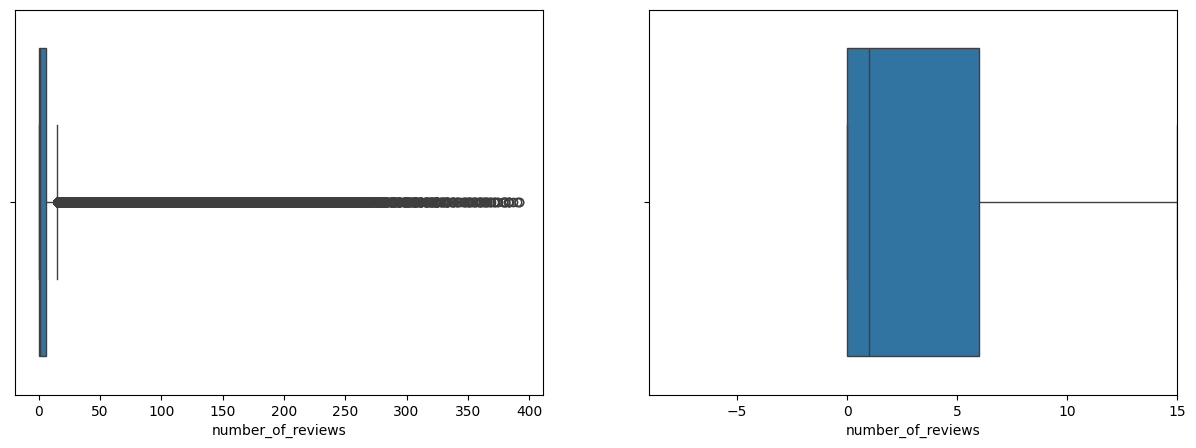

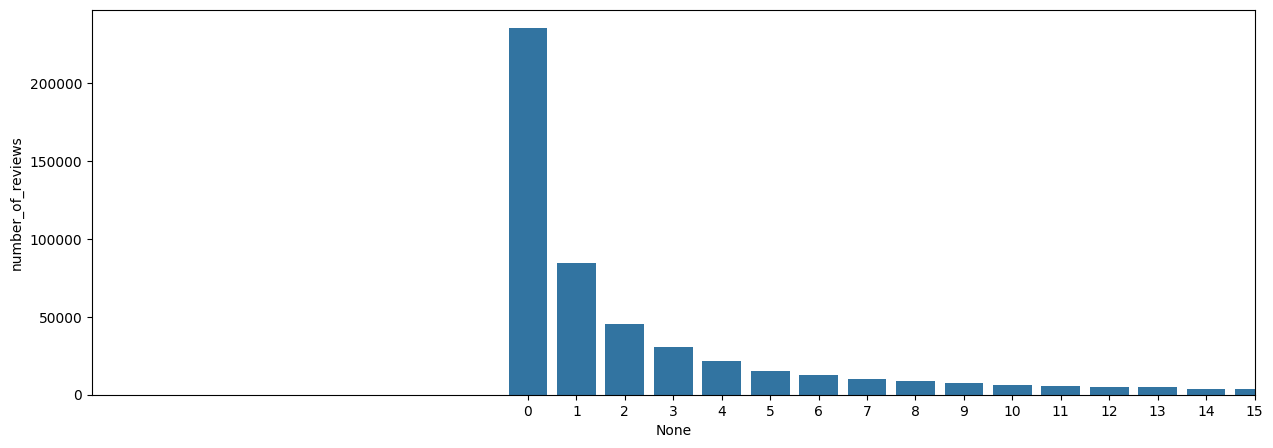

In [35]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

- Aqui poderíamos tomar algumas decisões diferentes. Eu vou tomar uma decisão baseado na minha análise pessoal de tirar essa característica da análise, por alguns motivos:

    1. Se excluirmos os outliers, vamos excluir as pessoas que tem a maior quantidade de reviews (o que normalmente são os hosts que têm mais aluguel). Isso pode impactar muito negativamente o nosso modelo
    2. Pensando no nosso objetivo, se eu tenho um imóvel parado e quero colocar meu imóvel lá, é claro que eu não tenho review nenhuma. Então talvez tirar essa característica da análise pode na verdade acabar ajudando.
    3. Particularmente tenho dúvida se essa característica deveria impactar ou não o preço final

In [36]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

### Tratamento de Colunas de Valores de Texto

### - property_type 

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

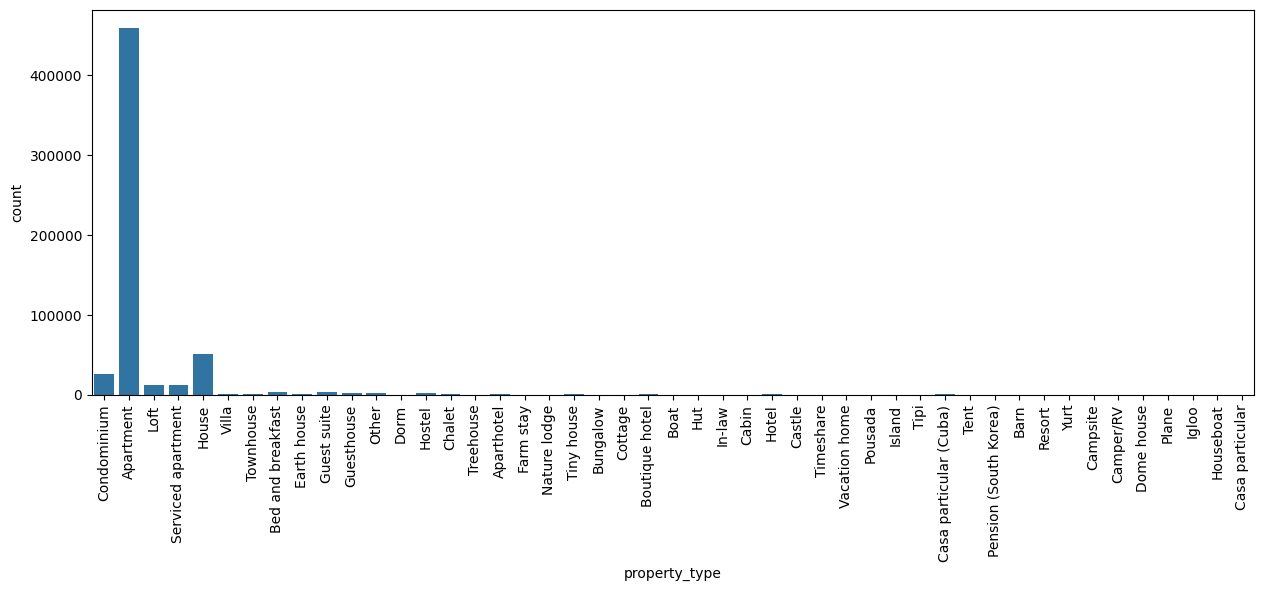

In [37]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base_airbnb, x='property_type')
grafico.tick_params(axis='x', rotation=90)

- Aqui a nossa ação será de agrupar valores que são muito pequenos.

- Vamos agrupar em um grupo chamado "outros" todos os tipos de propriedade que têm menos de 2.000 registros na base de dados

Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


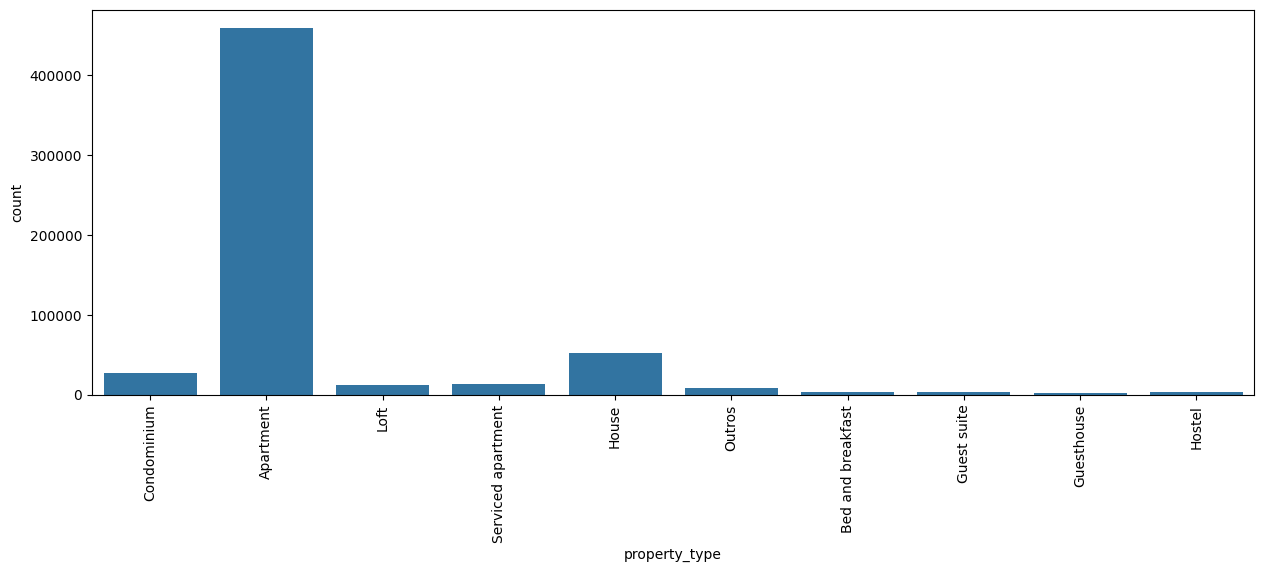

In [38]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)
# print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base_airbnb, x='property_type')
grafico.tick_params(axis='x', rotation=90)

### - room_type 

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


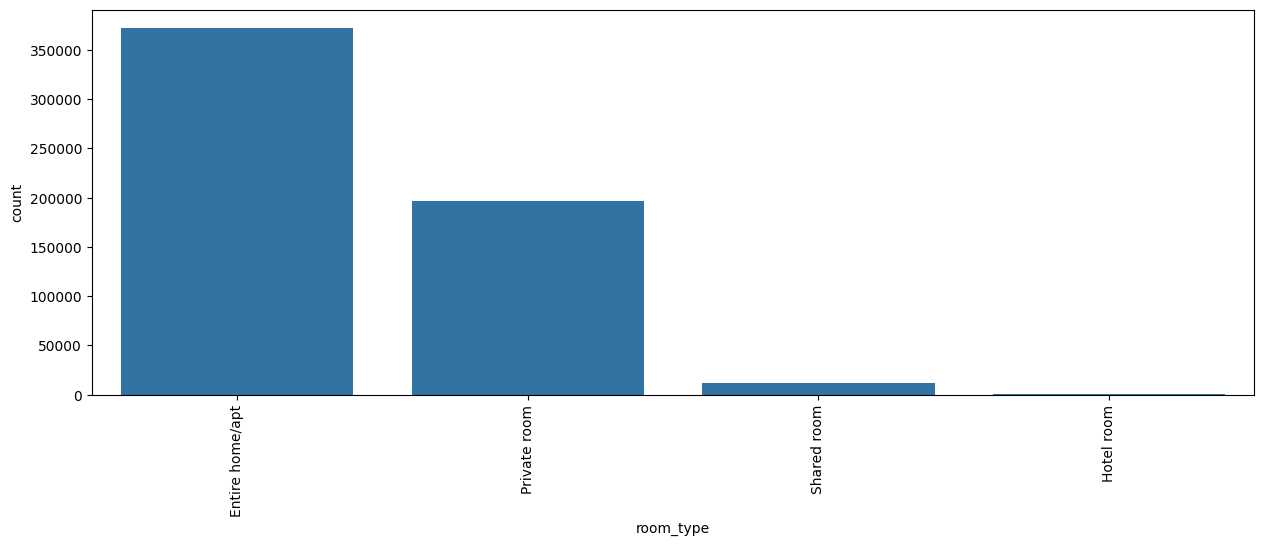

In [39]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base_airbnb, x='room_type')
grafico.tick_params(axis='x', rotation=90)

Em tipo de quarto, não precisamos fazer nada, ele já parece estar bem distribuído

### - bed_type 

Real Bed    570643
Outros       11340
Name: bed_type, dtype: int64


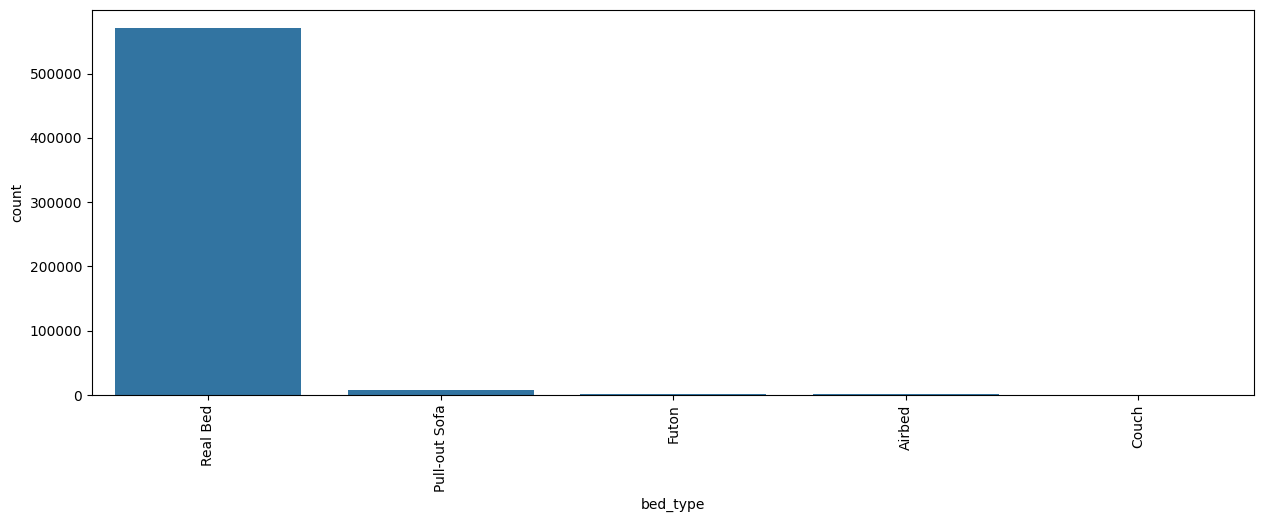

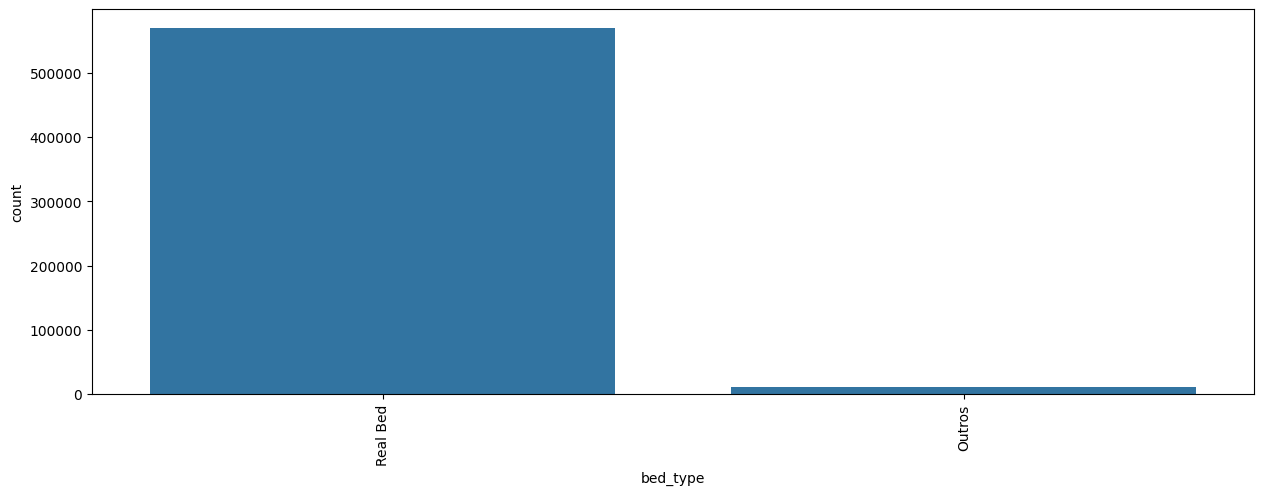

In [40]:
# print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base_airbnb, x='bed_type')
grafico.tick_params(axis='x', rotation=90)

# agrupando categorias de bed_type
tabela_bed = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_bed.index:
    if tabela_bed[tipo] < 10000:
        colunas_agrupar.append(tipo)
# print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'Outros'

print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base_airbnb, x='bed_type')
grafico.tick_params(axis='x', rotation=90)

- Aqui a nossa ação será agrupar valores que são muito pequenos.

- Como temos 1 valor claramente MUITO maior do que todos os outros, vou criar apenas 2 grupos de camas: "Real Bed" e "outros"

Isso vai simplificar o modelo

### - cancellation_policy 

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: cancellation_policy, dtype: int64


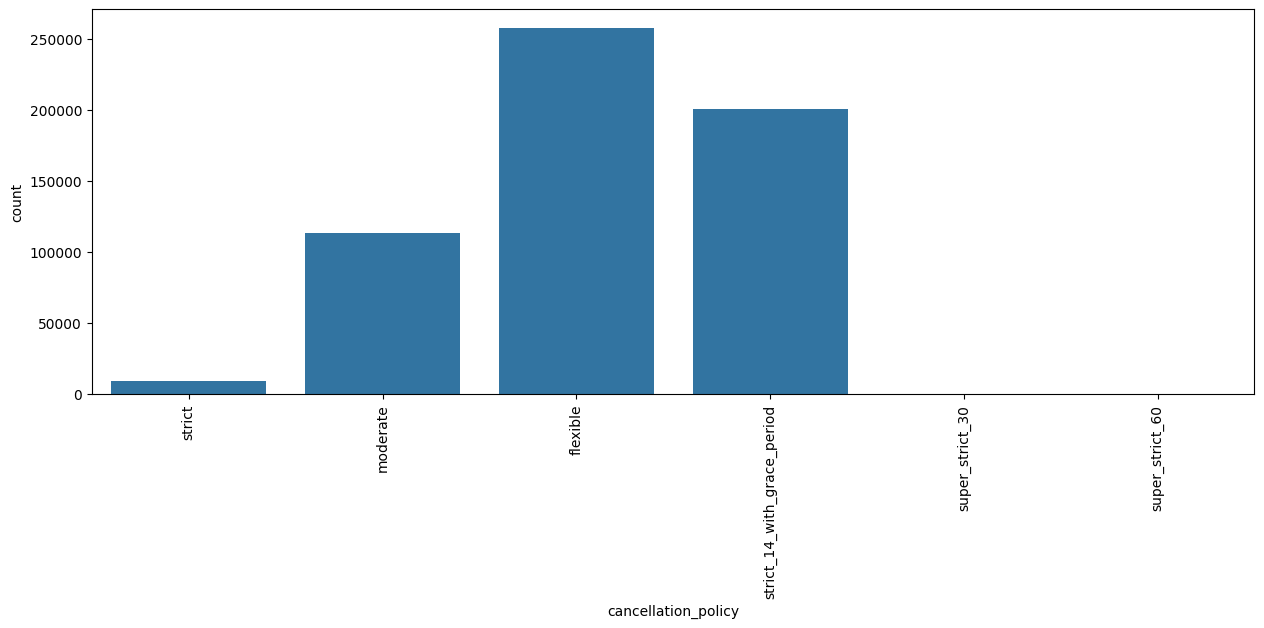

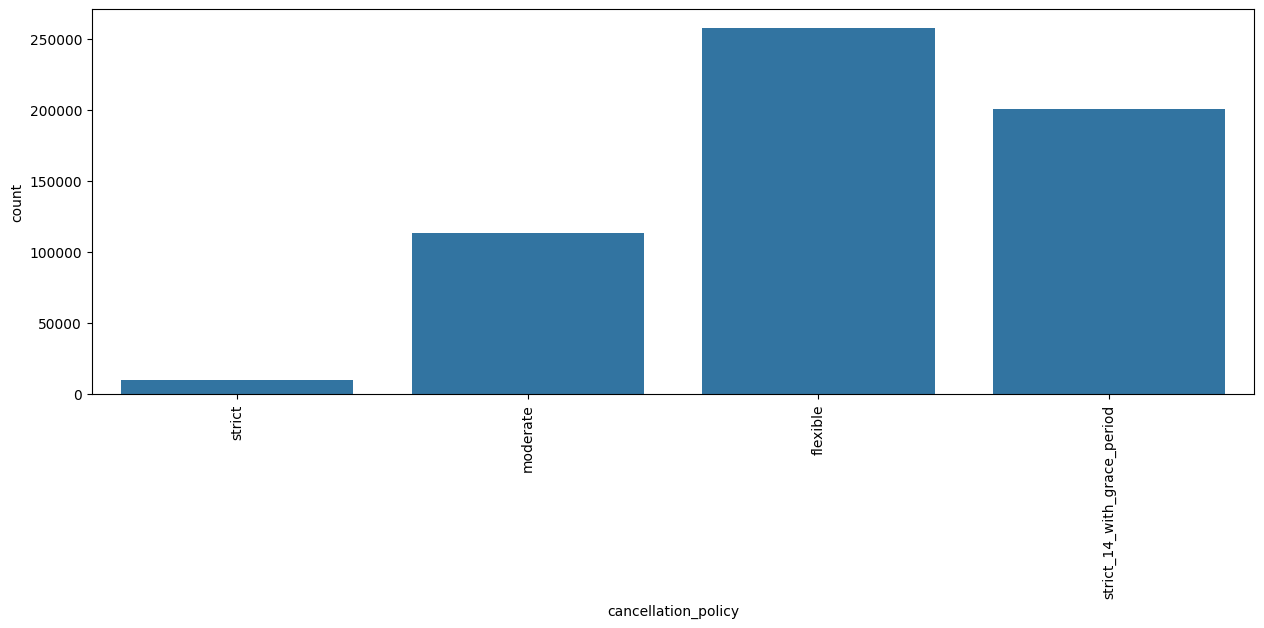

In [41]:
# print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base_airbnb, x='cancellation_policy')
grafico.tick_params(axis='x', rotation=90)

# agrupando categorias de cancellation_pollicy
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
# print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'

print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base_airbnb, x='cancellation_policy')
grafico.tick_params(axis='x', rotation=90)

### - amenities 

Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para o nosso modelo.

In [42]:
# print(base_airbnb['amenities'].iloc[1].split(','))
# print(len(base_airbnb['amenities'].iloc[1].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

In [43]:
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 20)

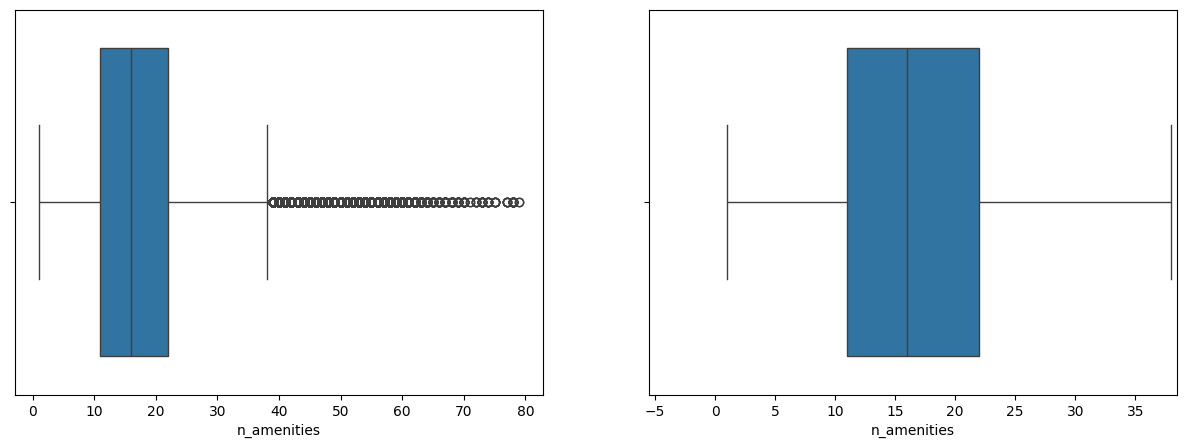

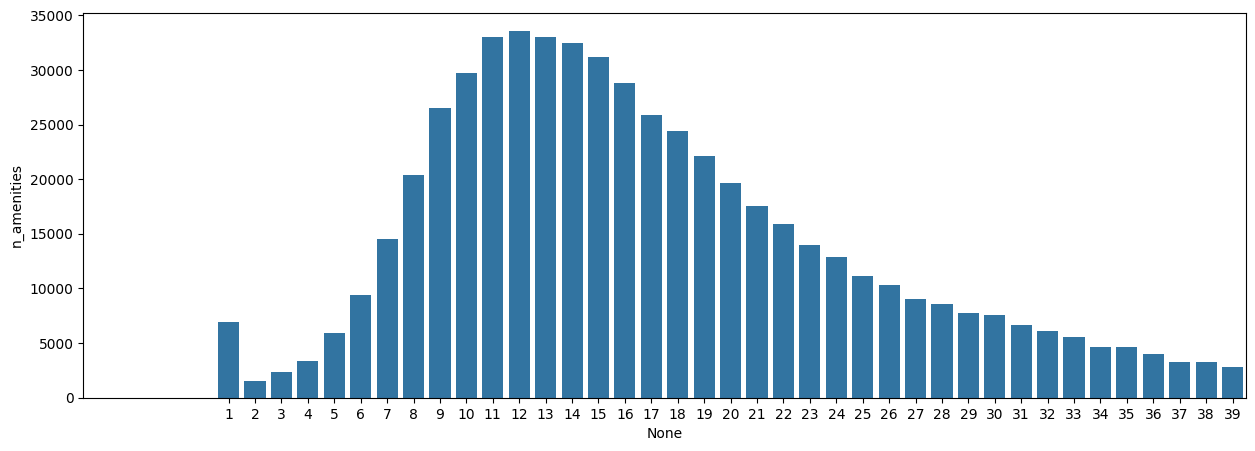

In [44]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

Então, essa virou uma coluna de valor numérico e, como todas as outras colunas de valores numéricos, eu exclui outliers com os mesmos modelos anteriores

In [45]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

24343 linhas removidas


### Visualização de Mapa das Propriedades

Vamos criar um mapa que exibe um pedaço da nossa base de dados aleatório (50.000 propriedades) para ver como as propriedades estão distribuídas pela cidade e também identificar os locais de maior preço 

In [46]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='open-street-map')
mapa.show()

### Encoding

Precisamor Ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies

In [47]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0

In [48]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod.head())

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   
6                 1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   
5        1.5       1.0   2.0  308.0          86.0  ...   
6        1.0       1.0   2.0  219.0          80.0  ...   

   room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
1                          1                    0                      0   
3                          1                    0                      0   
4                          1                    0                      0   
5                          1                    0                      0   
6                          1                    0                      0   

   room_type_Shared room  bed_type_Outros  bed_type_Real Bed  \
1                      0                0                  1   
3                      0                0                  1   
4                      0                0                  1   
5                      0                0                  1   
6                      0                0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   
6                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                           1                                                0  
3                           1                                                0  
4                           1                                                0  
5                           1                                                0  
6                           1                                                0  

[5 rows x 36 columns]

In [49]:
# Retirar os preços zerados
# Incluido após revisão da solução apresentada
base_airbnb_cod = base_airbnb_cod.loc[base_airbnb_cod['price']>0]

In [50]:
# Precisamos embaralhar os dados para que os dados de treinamento, teste e validação contenham dados de todos os meses e anos possíveis.
# Incluido após revisão da solução apresentada
base_airbnb_cod_shuffled = shuffle(base_airbnb_cod)

### Modelo de Previsão

- Métricas de Avaliação

Vamos usar aqui o R² que vai nos dizer o quão bem o nosso modelo consegue explicar o preço. Isso seria um ótimo parâmetro para ver o quão bom é nosso modelo <br>
-> Quanto mais próximo de 100%, melhor (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

Vamos também calcular o R² ajustado, aborda uma limitação do R², especialmente em regressão múltipla (modelos com mais de uma variável independente).

Vou calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o nosso modelo está errando. <br>
-> Quanto menor for o erro, melhor

In [51]:
def avaliar_modelo(nome_modelo, y_teste, previsao, X_test):
    r2 = r2_score(y_teste, previsao)
    Adj_r2 = 1 - (1-r2) * (len(y_teste)-1)/(len(y_teste)-X_test.shape[1]-1)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nR² Ajustado:{Adj_r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos Modelos a Serem Testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree
    4. Linear Support Vector Machine
    5. Stochastic Gradient Descent
    6. TensorFlow
    
Esses são alguns dos modelos que existem para fazer previsão de valores numéricos (o que chamamos de regressão). Estamos querendo calcular o preço, portanto, queremos prever um valor numérico.
https://scikit-learn.org/stable/supervised_learning.html

In [52]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()
# modelo_sv = make_pipeline(StandardScaler(), SVR()) # Demora muito
modelo_lsv = make_pipeline(StandardScaler(),
                           LinearSVR(random_state=0, tol=1e-5, dual=True))
modelo_sg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))

modelos = {
            'RandomForest': modelo_rf,
            'LinearRegression': modelo_lr,
            'ExtraTrees': modelo_et,
            #'Support Vector Machine': modelo_sv, # demora muito
            'Linear Support Vector Machine': modelo_lsv,
            'Stochastic Gradient Descent': modelo_sg,
          }

y = base_airbnb_cod_shuffled['price']
X = base_airbnb_cod_shuffled.drop('price', axis=1)

- Separa os dados em treino e teste + Treino do Modelo

Essa etapa é crucial. As Inteligências Artificiais aprendendo com o que chamamos de treino.

Basicamente o que a gente faz é: a gente separa as informações em treino e teste, ex: 10% da base de dados vai servir para teste e 90% para treino (normalmente treino é maior mesmo)

Aí, damos para o modelo os dados de treino, ele vai olhar aqueles dados e aprender a prever os preços.

Depois que ele aprende, você faz um teste com ele, com os dados de teste, para ver se ela está bom ou não. Analisando os dados de teste você descobre o melhor modelo

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    horainicio = datetime.datetime.now()
    #treinar
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test)
    fimteste = datetime.datetime.now()
    print(avaliar_modelo(nome_modelo, y_test, previsao, X_test))
    duration_total = (fimteste  - horainicio).total_seconds()
    print(f"Tempo total: {divmod(duration_total, 60)[0]}")
    print('#'*50)

Modelo RandomForest:
R²:97.30%
R² Ajustado:97.30%
RSME:43.43
Tempo total: 9.0
##################################################
Modelo LinearRegression:
R²:32.58%
R² Ajustado:32.57%
RSME:216.97
Tempo total: 0.0
##################################################
Modelo ExtraTrees:
R²:97.53%
R² Ajustado:97.53%
RSME:41.52
Tempo total: 11.0
##################################################
Modelo Linear Support Vector Machine:
R²:25.66%
R² Ajustado:25.64%
RSME:227.83
Tempo total: 0.0
##################################################
Modelo Stochastic Gradient Descent:
R²:32.36%
R² Ajustado:32.34%
RSME:217.33
Tempo total: 0.0
##################################################


# Avaliar modelo Tensorflor

In [ ]:
#display(base_airbnb_cod)

#print(base_airbnb_cod.dtypes)

In [ ]:
# # Tensorflow aceita apenas float
# base_airbnb_cod['host_is_superhost'] = base_airbnb_cod['host_is_superhost'].astype(np.float32, copy=False)
# base_airbnb_cod['accommodates'] = base_airbnb_cod['accommodates'].astype(np.float32, copy=False)
# base_airbnb_cod['minimum_nights'] = base_airbnb_cod['minimum_nights'].astype(np.float32, copy=False)
# base_airbnb_cod['instant_bookable'] = base_airbnb_cod['instant_bookable'].astype(np.float32, copy=False)
# base_airbnb_cod['is_business_travel_ready'] = base_airbnb_cod['is_business_travel_ready'].astype(np.float32, copy=False)
# base_airbnb_cod['ano'] = base_airbnb_cod['ano'].astype(np.float32, copy=False)
# base_airbnb_cod['mes'] = base_airbnb_cod['mes'].astype(np.float32, copy=False)
# base_airbnb_cod['n_amenities'] = base_airbnb_cod['n_amenities'].astype(np.float32, copy=False)
# base_airbnb_cod['property_type_Apartment'] = base_airbnb_cod['property_type_Apartment'].astype(np.float32, copy=False)
# base_airbnb_cod['property_type_Bed and breakfast'] = base_airbnb_cod['property_type_Bed and breakfast'].astype(np.float32, copy=False)
# base_airbnb_cod['property_type_Condominium'] = base_airbnb_cod['property_type_Condominium'].astype(np.float32, copy=False)
# base_airbnb_cod['property_type_Guest suite'] = base_airbnb_cod['property_type_Guest suite'].astype(np.float32, copy=False)
# base_airbnb_cod['property_type_Guesthouse'] = base_airbnb_cod['property_type_Guesthouse'].astype(np.float32, copy=False)
# base_airbnb_cod['property_type_Hostel'] = base_airbnb_cod['property_type_Hostel'].astype(np.float32, copy=False)
# base_airbnb_cod['property_type_House'] = base_airbnb_cod['property_type_House'].astype(np.float32, copy=False)
# base_airbnb_cod['property_type_Loft'] = base_airbnb_cod['property_type_Loft'].astype(np.float32, copy=False)
# base_airbnb_cod['property_type_Outros'] = base_airbnb_cod['property_type_Outros'].astype(np.float32, copy=False)
# base_airbnb_cod['property_type_Serviced apartment'] = base_airbnb_cod['property_type_Serviced apartment'].astype(np.float32, copy=False)
# base_airbnb_cod['room_type_Entire home/apt'] = base_airbnb_cod['room_type_Entire home/apt'].astype(np.float32, copy=False)
# base_airbnb_cod['room_type_Hotel room'] = base_airbnb_cod['room_type_Hotel room'].astype(np.float32, copy=False)
# base_airbnb_cod['room_type_Private room'] = base_airbnb_cod['room_type_Private room'].astype(np.float32, copy=False)
# base_airbnb_cod['room_type_Shared room'] = base_airbnb_cod['room_type_Shared room'].astype(np.float32, copy=False)
# base_airbnb_cod['bed_type_Outros'] = base_airbnb_cod['bed_type_Outros'].astype(np.float32, copy=False)
# base_airbnb_cod['bed_type_Real Bed'] = base_airbnb_cod['bed_type_Real Bed'].astype(np.float32, copy=False)
# base_airbnb_cod['cancellation_policy_flexible'] = base_airbnb_cod['cancellation_policy_flexible'].astype(np.float32, copy=False)
# base_airbnb_cod['cancellation_policy_moderate'] = base_airbnb_cod['cancellation_policy_moderate'].astype(np.float32, copy=False)
# base_airbnb_cod['cancellation_policy_strict'] = base_airbnb_cod['cancellation_policy_strict'].astype(np.float32, copy=False)
# base_airbnb_cod['cancellation_policy_strict_14_with_grace_period'] = base_airbnb_cod['cancellation_policy_strict_14_with_grace_period'].astype(np.float32, copy=False)


In [54]:
# Dividir o dataframe em bases treino, validação e teste

# Contar o número de dados
contagem_amostras = base_airbnb_cod_shuffled.shape[0]

# Numero de amostra em cada base, assumindo uma distribuição de 80-10-10 para treino, validação e teste
# Os numeros devem ser inteiros
contagem_treino = int(0.8 * contagem_amostras)
contagem_validacao = int(0.1 * contagem_amostras)

# A base de teste são os demais dados
contagem_teste = contagem_amostras - contagem_treino - contagem_validacao

shuffled_targets = base_airbnb_cod_shuffled['price']
shuffled_inputs = base_airbnb_cod_shuffled.drop('price', axis=1)

# Dimensionar os inputs e targets
# Dimensionar seus dados em aprendizado de máquina (ML) é importante porque muitos algoritmos usam a distância 
# euclidiana entre dois pontos de dados em seus cálculos/derivações, que é sensível à escala das variáveis. 
# Se uma variável estiver em uma escala muito maior que outra, essa variável dominará o cálculo da distância e 
# o algoritmo será mais afetado por essa variável do que pela outra. O dimensionamento dos dados pode ajudar a equilibrar 
# o impacto de todas as variáveis ​​no cálculo da distância e pode ajudar a melhorar o desempenho do algoritmo. Em particular, 
# várias técnicas de ML, como redes neurais, exigem que os dados de entrada sejam normalizados para que funcionem bem.
shuffled_inputs_scaled = preprocessing.scale(shuffled_inputs)
# shuffled_targets_scaled = preprocessing.scale(shuffled_targets)

# OU Sem dimensionar os inputs e targets
# shuffled_inputs_scaled = shuffled_inputs
shuffled_targets_scaled = shuffled_targets

# Criar variaveis para guardar os inputs e precos da base de treino, validação e teste
# Como a base está 'embaralhada', os primeiros dados serão de treino, em seguida validação e por fim teste
train_inputs = shuffled_inputs_scaled[:contagem_treino]
train_targets = shuffled_targets_scaled[:contagem_treino]

validation_inputs = shuffled_inputs_scaled[contagem_treino:contagem_treino+contagem_validacao]
validation_targets = shuffled_targets_scaled[contagem_treino:contagem_treino+contagem_validacao]

test_inputs = shuffled_inputs_scaled[contagem_treino+contagem_validacao:]
test_targets = shuffled_targets_scaled[contagem_treino+contagem_validacao:]

C:\Users\Thiago Kato\AppData\Local\Temp\ipykernel_8968\4286959796.py:34: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

C:\Users\Thiago Kato\AppData\Local\Temp\ipykernel_8968\4286959796.py:37: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

C:\Users\Thiago Kato\AppData\Local\Temp\ipykernel_8968\4286959796.py:40: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with

In [ ]:
# # Salvar os dados em arquivos *.npz para utilizacao futura
# np.savez('Airbnb_data_train', inputs=train_inputs, targets=train_targets)
# np.savez('Airbnb_data_validation', inputs=validation_inputs, targets=validation_targets)
# np.savez('Airbnb_data_test', inputs=test_inputs, targets=test_targets)

In [ ]:
# # Na variável npz, vamos guardar cada uma das bases salvas
# npz = np.load('Airbnb_data_train.npz')

# # Extraindo as informações e armazenando em variaveis de treino, validação e teste, tanto para inputs quanto para os targets
# train_inputs, train_targets = npz['inputs'].astype(np.float32), npz['targets'].astype(np.float32)


# npz = np.load('Airbnb_data_validation.npz')
# validation_inputs, validation_targets = npz['inputs'].astype(np.float32), npz['targets'].astype(np.float32)

# npz = np.load('Airbnb_data_test.npz')
# test_inputs, test_targets = npz['inputs'].astype(np.float32), npz['targets'].astype(np.float32)

In [57]:
# Definir o tamanho do output
output_size = 1

# Defnir o tamanho do hidden layer. Nao ha necessidade de usar o mesmo tamanhp
hidden_layer_size = 200
    
# Definicao do modelo
model = tf.keras.Sequential([
    # tf.keras.layers.Dense is basically implementing: output = activation(dot(input, weight) + bias)
    # it takes several arguments, but the most important ones for us are the hidden_layer_size and the activation function
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
    
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),

    #tf.keras.layers.Dense(36, activation='relu'), # extra layers
    #tf.keras.layers.Dense(18, activation='relu'), # extra layers
    #tf.keras.layers.Dense(9, activation='relu'), # extra layers
    #tf.keras.layers.Dense(4, activation='relu'), # extra layers
    #tf.keras.layers.Dense(2, activation='relu'), # extra layers

    # O layer final não é diferente. Ferificar a melhor função de ativação
    #tf.keras.layers.Dense(output_size, activation='softplus') # output layer
    tf.keras.layers.Dense(output_size) # output layer
])


### Escolha do otimizador e a função de perda
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
#model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['accuracy'])
#model.compile(optimizer='RMSProp', loss='mean_squared_error', metrics=['accuracy'])
#model.compile(optimizer='Nadam', loss='mean_squared_error', metrics=['accuracy'])

### Treinamento do modelo
# definir o tamanho do lote
batch_size = 40

# Definir o numero maximo de epocas
max_epochs = 50

# Definir um mecanismo de parada antecipada (early stopping)
# Definir patience=2, para ter uma certa tolerancia ao aumento das perdas
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

# fit the model
model.fit(train_inputs, # Input de treinamento
          train_targets, # Targets de treinamento
          batch_size=batch_size, # tamanho do lote
          epochs=max_epochs, # epocas de treinamento (assumindo que nao haja parada antecipada)
          # verifica se a perda esta aumentando
          callbacks=[early_stopping], # early stopping
          validation_data=(validation_inputs, validation_targets), # dados de validacao
          verbose = 2 # informacoes sobre o processo de treinamento
          )  

Epoch 1/50
11152/11152 - 53s - 5ms/step - accuracy: 0.0000e+00 - loss: 41336.4375 - val_accuracy: 0.0000e+00 - val_loss: 38604.7188
Epoch 2/50
11152/11152 - 80s - 7ms/step - accuracy: 0.0000e+00 - loss: 37142.7656 - val_accuracy: 0.0000e+00 - val_loss: 34946.1328
Epoch 3/50
11152/11152 - 45s - 4ms/step - accuracy: 0.0000e+00 - loss: 32934.0312 - val_accuracy: 0.0000e+00 - val_loss: 30927.8086
Epoch 4/50
11152/11152 - 45s - 4ms/step - accuracy: 0.0000e+00 - loss: 28662.3809 - val_accuracy: 0.0000e+00 - val_loss: 27210.4785
Epoch 5/50
11152/11152 - 44s - 4ms/step - accuracy: 0.0000e+00 - loss: 25085.4141 - val_accuracy: 0.0000e+00 - val_loss: 23443.2090
Epoch 6/50
11152/11152 - 47s - 4ms/step - accuracy: 0.0000e+00 - loss: 22065.6074 - val_accuracy: 0.0000e+00 - val_loss: 21699.0449
Epoch 7/50
11152/11152 - 79s - 7ms/step - accuracy: 0.0000e+00 - loss: 19635.6504 - val_accuracy: 0.0000e+00 - val_loss: 18749.5645
Epoch 8/50
11152/11152 - 45s - 4ms/step - accuracy: 0.0000e+00 - loss: 17629

In [58]:
prev = model.predict(test_inputs)

print(avaliar_modelo('TensorFlow', test_targets, prev, test_inputs))

# Sem dimensionar o resultado foi 37,46% com RSME 209.01
# Dimensionando apenas os inputs: 47,77% com RSME 191.01
# Dimensionando inputs e usando output activation softmax:  -147.87% e RSME 416.11
# Dimensionando inputs e usando output activation sigmoid:  -147.87% e RSME 416.11
# Dimensionando inputs e usando output activation relu:  47.29% e RSME 191.88
# Dimensionando inputs e usando output activation selu:  46.48% e RSME 193.35
# Dimensionando inputs e usando output activation softplus:  46.45% e RSME 193.41
# Dimensionando apenas os inputs, incluindo 5 layes extras reduzindo tamanho, sem output activation: -0,00% com RSME 264.30 
# Dimensionando apenas os inputs, incluindo 2 layes extras mesmo tamanho, sem output activation: 60,28% com RSME 166.57 
# Dimensionando apenas os inputs, incluindo 4 layes extras mesmo tamanho, sem output activation: 66,98% com RSME 151.88 
# Dimensionando apenas os inputs, incluindo 4 layes extras mesmo tamanho, sem output activation, hidden layer 100: 80.25% com RSME 117.46 
# Dimensionando apenas os inputs, incluindo 4 layes extras mesmo tamanho, sem output activation, hidden layer 200: 84.47% com RSME 104.17 
# Dimensionando apenas os inputs, incluindo 4 layes extras mesmo tamanho, sem output activation, hidden layer 200: 89.87% com RSME 83.90 - rodando segunda vez mesmas

1743/1743 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Modelo TensorFlow:
R²:87.46%
R² Ajustado:87.45%
RSME:92.95


### Análise do Melhor Modelo

In [59]:
for nome_modelo, modelo in modelos.items():
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao, X_test))
print(avaliar_modelo('TensorFlow', test_targets, prev, test_inputs))

Modelo RandomForest:
R²:97.30%
R² Ajustado:97.30%
RSME:43.43
Modelo LinearRegression:
R²:32.58%
R² Ajustado:32.57%
RSME:216.97
Modelo ExtraTrees:
R²:97.53%
R² Ajustado:97.53%
RSME:41.52
Modelo Linear Support Vector Machine:
R²:25.66%
R² Ajustado:25.64%
RSME:227.83
Modelo Stochastic Gradient Descent:
R²:32.36%
R² Ajustado:32.34%
RSME:217.33
Modelo TensorFlow:
R²:87.46%
R² Ajustado:87.45%
RSME:92.95


- Modelo Escolhido como Melhor Modelo: ExtraTressRegressor

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME), vamos escolher o Modelo ExtraTrees.
    
    O modelo utilizando o TensorFlow além do tempo de processamento, obteve um resultado abaixo dos melhores modelos em Scykit
    
    O modelo de regressão linear não obteve um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.
    
- Resultados das Métricas de Avaliacao no Modelo Vencedor:<br>
Modelo ExtraTrees:<br>
R²:97.45%<br>
RSME:42.37

### Ajustes e Melhorias no Melhor Modelo

0
bedrooms                                         0.115191
latitude                                         0.104106
longitude                                        0.101456
n_amenities                                      0.088669
extra_people                                     0.087400
accommodates                                     0.072277
bathrooms                                        0.068286
room_type_Entire home/apt                        0.067025
minimum_nights                                   0.064680
beds                                             0.052319
host_listings_count                              0.039697
instant_bookable                                 0.021788
cancellation_policy_flexible                     0.019426
host_is_superhost                                0.013359
property_type_Apartment                          0.012674
cancellation_policy_moderate                     0.012497
ano                                              0.011335
cancellation_policy_strict_14_with_grace_period  0.007720
property_type_House                              0.007215
property_type_Condominium                        0.005291
mes                                              0.004658
room_type_Private room                           0.004149
bed_type_Real Bed                                0.002694
bed_type_Outros                                  0.002655
property_type_Serviced apartment                 0.002296
property_type_Loft                               0.002293
property_type_Outros                             0.002282
room_type_Shared room                            0.001806
property_type_Bed and breakfast                  0.001327
property_type_Guesthouse                         0.000911
cancellation_policy_strict                       0.000868
property_type_Guest suite                        0.000699
property_type_Hostel                             0.000643
room_type_Hotel room                             0.000308
is_business_travel_ready                         0.000000

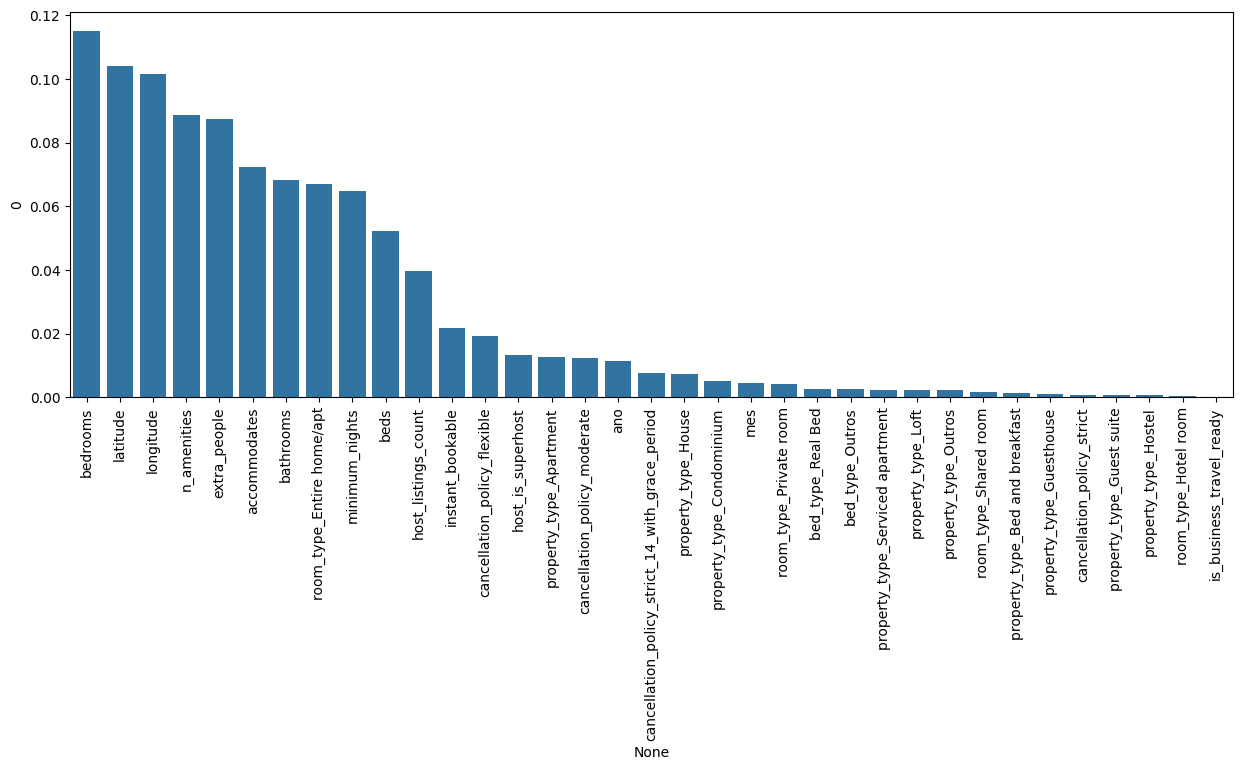

In [60]:
#print(modelo_et.feature_importances_)
#print(X_train.columns)
importancia_features = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes Finais no Modelo

- is_business_travel ready nao apresenta impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [61]:
base_airbnb_cod_shuffled = base_airbnb_cod_shuffled.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod_shuffled['price']
X = base_airbnb_cod_shuffled.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao, X_test))

Modelo ExtraTrees:
R²:97.55%
R² Ajustado:97.55%
RSME:41.39


In [62]:
base_teste = base_airbnb_cod_shuffled.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:    
        base_teste = base_teste.drop(coluna, axis=1)
#print(base_teste.columns)
y = base_teste['price']
X = base_teste.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao, X_test))

Modelo ExtraTrees:
R²:97.54%
R² Ajustado:97.54%
RSME:41.46
